In [12]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge

from reservoirpy.observables import nrmse, rsquare

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

In [13]:
from reservoirpy.datasets import doublescroll

timesteps = 2510
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")

In [14]:
from reservoirpy.datasets import to_forecasting

train_len = 2000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:2000], y[:2000]
X_test, y_test = x[2000:], y[2000:]

dataset = ((X_train, y_train), (X_test, y_test))

In [15]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [16]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.9
lr = 0.8310012558635558
ridge = 1e-7
seed = 1234
sr = 0.2237449778907503

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.0001579050277040674
R^2: 0.999999322598545


In [17]:
seed_timesteps = 100

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup

In [18]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 3))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = model(y)
    X_gen[t, :] = y

In [19]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [28]:
warming_out

array([[ 3.43754433, -1.27489405, -1.24852747],
       [ 1.34657348,  0.29672572,  0.15372919],
       [ 0.78873151,  0.24093729,  1.12125944],
       [ 0.6131899 , -0.0631819 ,  1.48539001],
       [ 0.49138602, -0.3070806 ,  1.50246713],
       [ 0.36418581, -0.48369891,  1.3717436 ],
       [ 0.23135703, -0.61834161,  1.18152138],
       [ 0.10430181, -0.72815235,  0.96391633],
       [-0.01811644, -0.80987333,  0.73101946],
       [-0.13040554, -0.86607509,  0.49121465],
       [-0.23871265, -0.88923886,  0.25320372],
       [-0.34845813, -0.8748987 ,  0.02506014],
       [-0.46658323, -0.82105328, -0.18369157],
       [-0.59462531, -0.73415405, -0.36493521],
       [-0.7338881 , -0.62225403, -0.51339874],
       [-0.88767521, -0.49337794, -0.62552112],
       [-1.0432728 , -0.37219799, -0.70135887],
       [-1.1602523 , -0.30485142, -0.7492897 ],
       [-1.20272737, -0.31723063, -0.78851896],
       [-1.22777224, -0.3422466 , -0.83294983],
       [-1.25312496, -0.36155106, -0.879

In [30]:
seed_timesteps

100

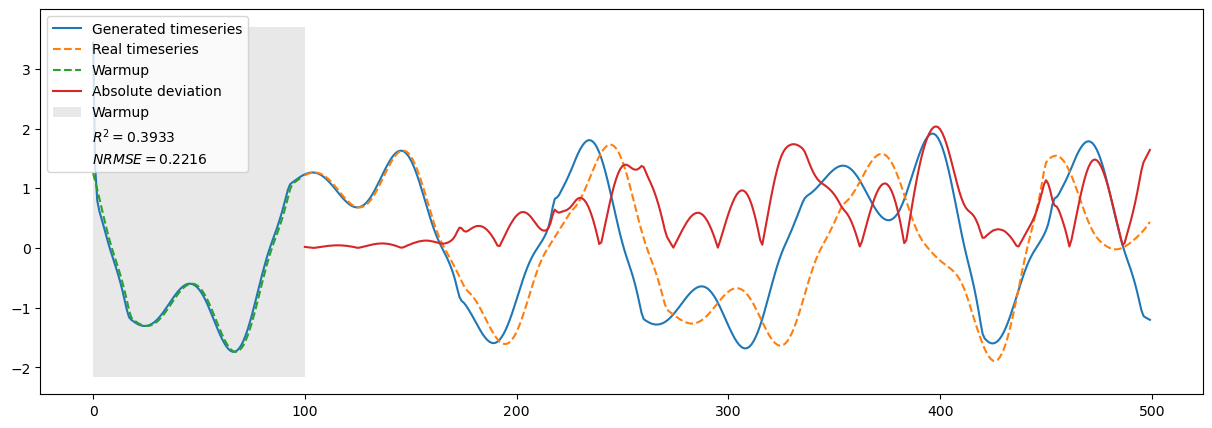

In [29]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps][:, :1]

#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, :1], X_t_X, nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

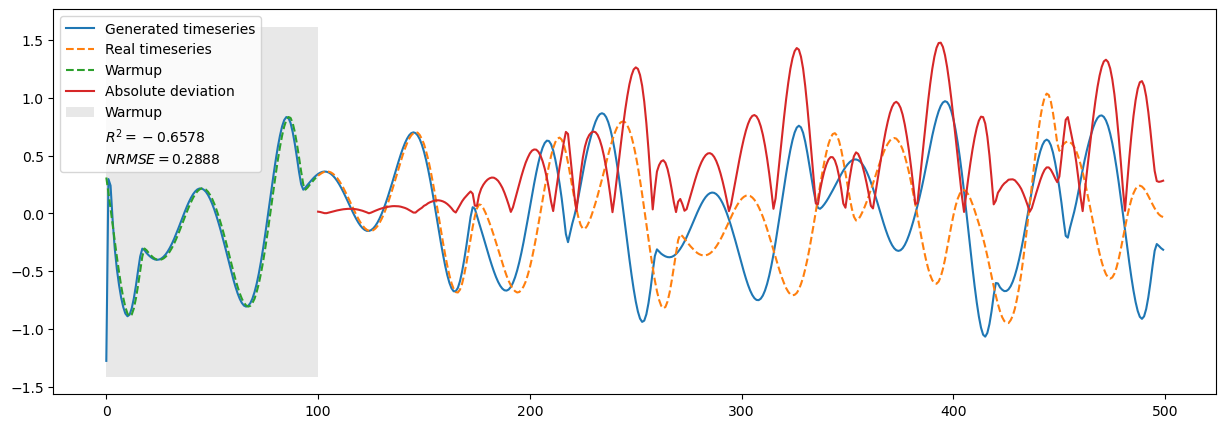

In [21]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps][:, 1:2]

#Double Scroll AttractorのYを描画する
plot_generation(X_gen[:, 1:2], X_t_X, nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

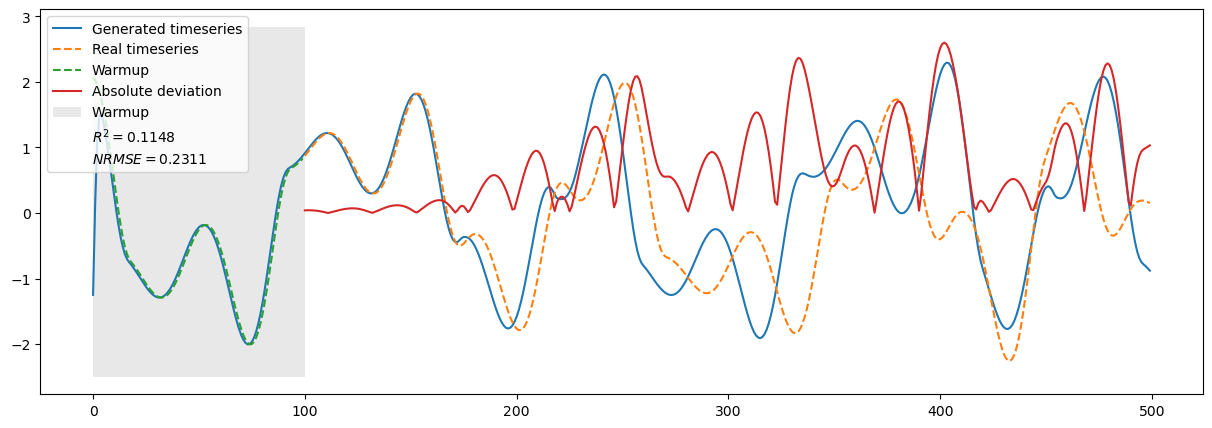

In [22]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps][:, 2:3]

#Double Scroll AttractorのZを描画する
plot_generation(X_gen[:, 2:3], X_t_X, nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)